This notebook will allow anyone to reproduce figures including the triangle plot, redshift vs. rates, metallicity, delay time distribution, and the final master plot that displays the variations. 

Before we make each plot we must make sure that we run fast cosmic integration on my version of COMPAS. We must then check to make sure the py script that contains each of these plotting functions works as well.

We then want to make sure we know how many systems of each type there are using the "systems_of_interest_counter" function we created.

For the triangle plot:
- read in the data + mask the data
- use the masses, mixture weights, and rates to plot the triangle plot

For the redshift vs. rates plot:
- read in the data + mask the data
- calculate the rates of the masked data
- gather the rates, redshifts, mixture weights, stellar types, and masses of the systems
- plot the rate of COWD + WD

For the metallicity plot:
- read in the data + mask the data
- gather the metallicities, stellar types, mixture weights, and masses of the systems
- plot the metallicity

For the delay time distribution plot:
- read in the data + mask the data
- gather the masses, stellar types, and mixture weights

In [1]:
#imports!

# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns
import matplotlib as mpl

# Add the subdir to sys.path for our created scripts
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')
sys.path.append('/home/jovyan/home/research_work/making_figures/paper_figures/')

# Now you can import the module
import useful_fncs
import figure_utils
import utils_from_others

# import for axes labels 
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

## Counting Our Systems

In [2]:
pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
figure_utils.systems_of_interest_counter(pathToH5)

There are 144 NSNS systems from the DCO mask.
There are 2820201 WDWD systems from the DCO masks.
There are 2777344 COWD systems from the DCO masks.


## Triangle Plot

### 1) Reading in the data

In [2]:
# Set the appropriate path to the data file + read in the data

pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
Data  = h5.File(pathToH5, "r")

In [3]:
# we want to use information in the double compact object group
DCOs = Data['BSE_Double_Compact_Objects']
# gathering the double compact objects that we have computed rates for
DCO_mask = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]

# first we want to investigate how many of each type of DCO there is
stellar_types_1 = DCOs['Stellar_Type(1)'][()][DCO_mask]
stellar_types_2 = DCOs['Stellar_Type(2)'][()][DCO_mask]


# we need the masses, mixture weight, and rate info
mass1 = DCOs['Mass(1)'][()][DCO_mask]
mass2 = DCOs['Mass(2)'][()][DCO_mask]
rates_z0_DCO = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]


In [4]:
# let's add everything to a dataframe so we can analyze things easier

data = {
  "Stellar_Type(1)": stellar_types_1,
  "Stellar_Type(2)": stellar_types_2,
  "Mass(1)": mass1,
  "Mass(2)": mass2
}

DCOs_masked = pd.DataFrame(data)
DCOs_masked

,Stellar_Type(1),Stellar_Type(2),Mass(1),Mass(2)
0,11,11,0.676376,0.561591
1,10,10,0.400179,0.248276
2,11,11,0.554287,0.541801
3,11,10,0.725976,0.174049
4,10,10,0.318765,0.172958
...,...,...,...,...
2851586,11,11,0.559885,0.292593
2851587,11,10,0.781055,0.306811
2851588,11,11,0.766494,0.659636
2851589,11,10,0.853889,0.241995


### 2) Analyze the Data

In [21]:
# let's first count how many NSNS, NSWD, and WDWD systems there are

NSNS_systems_bool = np.logical_and(stellar_types_1==14, stellar_types_2==14)
print("There are {} NSNS systems." .format(sum(NSNS_systems_bool)))

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(DCOs_masked)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
print("There are {} COWD systems." .format(sum(carbon_oxygen_bool)))


WDWD_bool = np.logical_and(np.isin(stellar_types_1,[10,11,12]),np.isin(stellar_types_2,[10,11,12]))
print("There are {} WDWD systems." .format(sum(WDWD_bool)))

There are 144 NSNS systems.
There are 2777344 COWD systems.
There are 2820201 WDWD systems.


### 3) Let's now make the triangle plot!

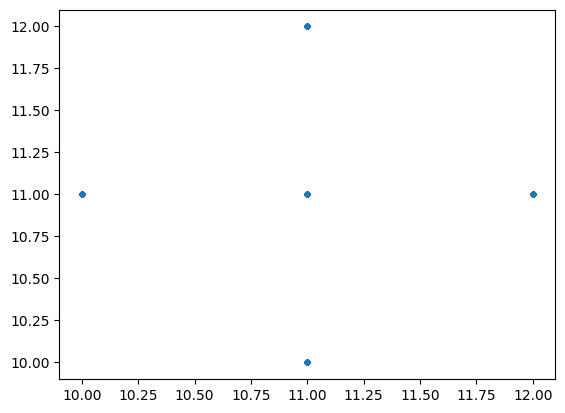

In [24]:
# let's make sure we are only selecting WDWDs
stellar_type_1 = np.array(DCOs['Stellar_Type(1)'][DCO_mask])
stellar_type_2 = np.array(DCOs['Stellar_Type(2)'][DCO_mask])
plt.plot(stellar_type_1[carbon_oxygen_bool], stellar_type_2[carbon_oxygen_bool],'.')

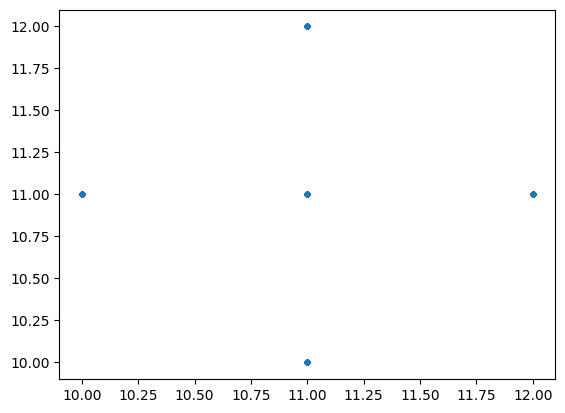

In [25]:
# let's make sure that the dataframe we set up gives the same results (aka did not mess up the data somehow)

plt.plot(stellar_types_1[carbon_oxygen_bool], stellar_types_2[carbon_oxygen_bool],'.')

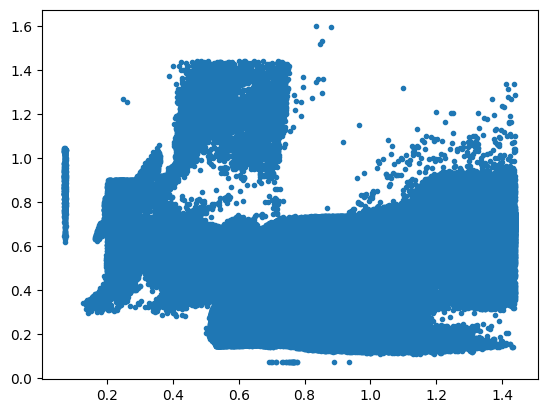

In [26]:
Mass1 = np.array(mass1[carbon_oxygen_bool])
Mass2 = np.array(mass2[carbon_oxygen_bool])
plt.plot(Mass1, Mass2, '.')

In [27]:
# let's then make sure that M1 refers to the more massive WD and M2 refers to the less massive one
M1 = np.maximum(Mass1, Mass2)
M2 = np.minimum(Mass1, Mass2)

0.0 8040.939127470035


Text(0, 0.5, '$M_{2}$[$M_{\\odot}$]')

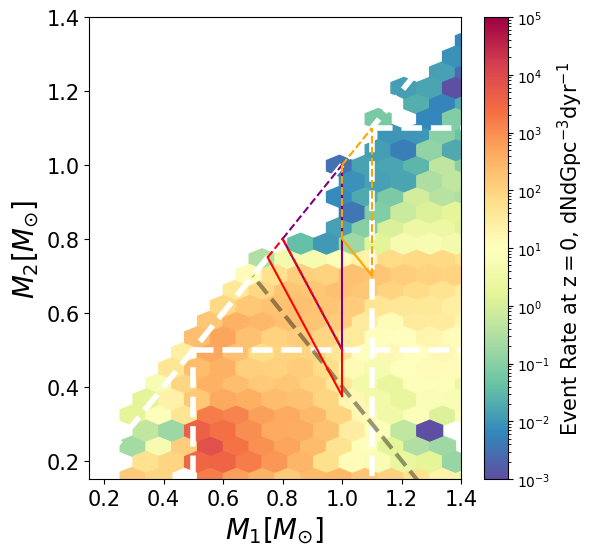

In [29]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

# let's define a few things first
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
vmin = 10**-3
vmax = 10**5


# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = plt.hexbin(M1,M2,C=WDWD_merger_rate_Z0, gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram
print(min(zvalue_array),max(zvalue_array)) # helps us detemine what vim and vmax should be and what the bin size should be 

# colorbar
cb = plt.colorbar()
cb.set_label(label="Event Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
plt.ylim(0.15,max_mass_lim)
plt.xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(M1)
ylim = max(M1)

linecolors = 'white'
linewidths = 4

plt.axline((0,0), (max(mass1[carbon_oxygen_bool]),max(mass1[carbon_oxygen_bool])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
plt.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
plt.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
plt.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 

# # chandrasekar mass line
plt.plot((1.4,0.7),(0,0.7),color='black', lw=3, ls='--', alpha = 0.4)


# red region - hypervelocity WDs
plt.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
plt.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
plt.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
plt.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
plt.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
plt.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
plt.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
plt.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary



plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
plt.ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)

# increase tick label sizes

## save figure:
# plt.savefig("./figures/triangle_plots/triangle_CEalpha1.png",bbox_inches='tight',pad_inches=0.1)

### 4) Let's close the file!

In [32]:
Data.close()

### 5) Let's make sure the function from the py script outputs the same result

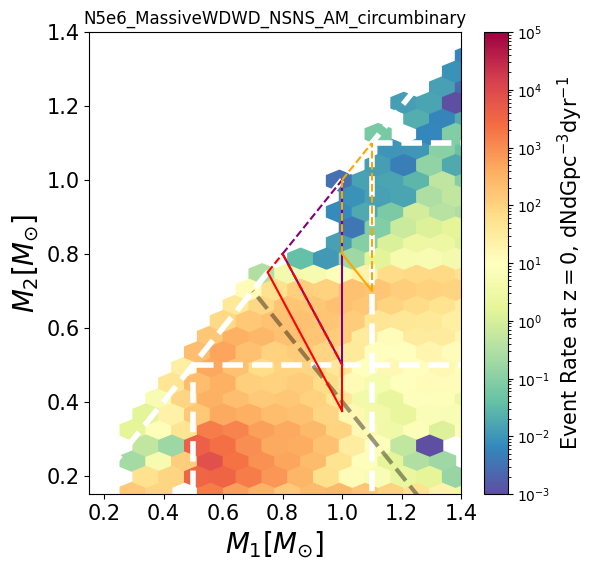

In [2]:
pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
title = 'N5e6_MassiveWDWD_NSNS_AM_circumbinary'
figure_utils.triangle_plot_fnc(pathToH5, title)

## Redshift Rates Plot

### 1) Read in the data

In [2]:
# Set the appropriate path to the data file + read in the data

pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
Data  = h5.File(pathToH5, "r")

In [ ]:
# let's gather the data we need for the redshift rates plots

# we want to use information in the double compact object group
DCOs = Data['BSE_Double_Compact_Objects']
# gathering the double compact objects that we have computed rates for
DCO_mask = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]

# first we want to investigate how many of each type of DCO there is
stellar_types_1 = DCOs['Stellar_Type(1)'][()][DCO_mask]
stellar_types_2 = DCOs['Stellar_Type(2)'][()][DCO_mask]


# we need the masses
mass1 = DCOs['Mass(1)'][()][DCO_mask]
mass2 = DCOs['Mass(2)'][()][DCO_mask]

# we also need the rates and redshift data
rates_DCO = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
redshifts = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]


The added redshifts and rates columns are not one dimensional arrays so reading them in takes much longer than the other keys. I need to find a way to make reading both of them in a shorter process because doing so has added at least 2 mins to run time for a total of about a 3 min run time.

In [4]:
# let's add everything to a dataframe so we can analyze things easier

data = {
  "Stellar_Type(1)": stellar_types_1,
  "Stellar_Type(2)": stellar_types_2,
  "Mass(1)": mass1,
  "Mass(2)": mass2
}

DCOs_masked = pd.DataFrame(data)

### 2) Analyze the Data + Compute the Rates

In [ ]:
# let's now calculate the rates of these systems of interest
# a run time of about a minute
cowd_rate = np.sum(rates_DCO[carbon_oxygen_bool], axis=0)

In [7]:
# let's do this again but for NSNS systems
NSNS_rate = np.sum(rates_DCO[NSNS_systems_bool], axis=0)

Computing the rates took about a minute...maybe we can find a way to reduce this time.

### 3) Define constants needed for the plot

In [8]:
# extracting the redshifts and rates from Briel et al
# units in the appendix should be in h^-3 y^-1 Gpc^-3 so we must convert below to get yr^-1 Gpc^-3
h_little = 0.6766

redshifts_briel = [
    0, 0.01, 0.03, (0.025+0.050)/2, 0.073, (0.05+0.15)/2, (0.075+0.125)/2, 0.11, 0.11, 0.13, 
    0.15, (0.125+0.175)/2, 0.16, (0.175+0.225)/2, 0.2, 0.25, (0.15+0.35)/2, (0.225+0.275)/2, 
    0.26, 0.3, (0.275+0.325)/2, 0.35, 0.35, 0.42, 0.44, 0.45, 0.45, (0.35+0.55)/2, 0.46, 0.47, 
    0.47, 0.55, 0.55, 0.55, 0.62, 0.65, (0.55+0.75)/2, 0.65, 0.74, 0.75, 0.75, 0.75, 0.8, 0.83, 0.85, 
    0.85, 0.94, 0.95, 0.95, 1.05, 1.1, 1.14, 1.21, 1.23, 1.25, 1.59, 1.61, 1.69, 1.75, 2.25
]

rates_briel = [
    0.77, 0.82, 0.82, 0.81, 0.71, 1.60, 0.76, 1.08, 0.72, 0.58, 0.93, 0.90, 0.41, 1.01, 0.58,
    1.05, 1.14, 1.06, 0.82, 0.99, 1.27, 0.99, 1.05, 1.34, 0.76, 0.90, 1.05, 1.52, 1.40, 1.22, 
    2.33, 0.93, 1.40, 1.52, 3.76, 1.40, 2.01, 1.43, 2.30, 1.49, 1.98, 1.69, 2.45, 3.79, 2.27, 
    1.66, 1.31, 2.22, 2.24, 2.30, 2.16, 2.06, 3.85, 2.45, 1.87, 1.31, 1.22, 2.97, 2.10, 1.43
]

# converting the rates to the correct units
rates_briel = np.array(rates_briel)
converted_rates_briel = (rates_briel*(10**5))*(h_little**3)

## uncertainties
lower_limits = [
    -0.10, -0.26, -0.32, -0.24, -0.08, -0.85, -0.13, -0.29, -0.20, -0.18, -0.67, -0.10, -0.26, -0.09, 
    -0.23, -0.76, -0.35, -0.08, -0.20, -0.44, -0.10, -0.55, -0.17, -0.93, -0.39, -0.44, -0.17, -0.38, 
    -0.50, -0.17, -0.79, -0.41, -0.17, -0.26, -1.66, -0.15, -0.52, -0.50, -1.20, -0.55, -0.61, -0.17, 
    -0.54, -0.79, -0.64, -0.15, -0.55, -0.73, -0.23, -0.82, -0.35, -0.53, -0.85, -0.82, -0.64, -0.64, 
    -0.67, -1.08, -0.87, -1.11
]

lower_limits = np.array(lower_limits)
converted_lower_limits = (lower_limits*(10**5)*(h_little**3))

upper_limits = [
    0.10, 0.26, 0.32, 0.33, 0.08, 1.46, 0.15, 0.29, 0.08, 0.20, 0.67, 0.11, 0.26, 0.09, 0.23,
    1.75, 0.38, 0.09, 0.20, 0.47, 0.11, 0.55, 0.17, 1.22, 0.67, 0.44, 0.17, 0.32, 0.50, 0.17, 
    1.08, 0.41, 0.17, 0.29, 2.57, 0.15, 0.55, 0.50, 0.96, 0.79, 0.61, 0.17, 0.67, 0.96, 0.64, 
    0.15, 0.64, 0.73, 0.23, 0.82, 0.35, 0.70, 1.05, 0.73, 0.90, 0.99, 1.14, 1.57, 1.31, 2.77
]

upper_limits = np.array(upper_limits)
converted_upper_limits = (upper_limits*(10**5)*(h_little**3))

# multiplied the lower errors by -1 so make them positive to avoid the plt.errorbar error 
y_error = [-1*(converted_lower_limits), converted_upper_limits]
# y_error = [converted_rates_briel+ converted_lower_limits, converted_rates_briel + converted_upper_limits]
# converted_y_error = y_error*(10**5)*(0.6766)

# error_bars = y_error


### 4) Plot!

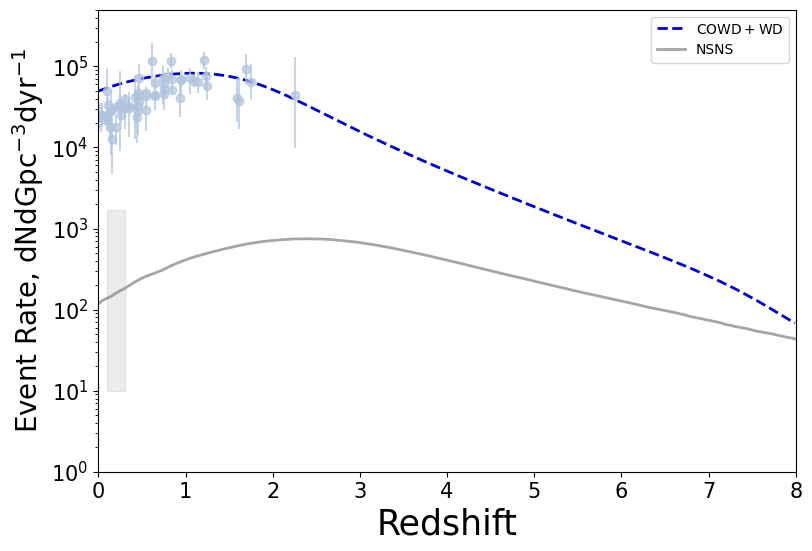

In [9]:
# disitninuish things merging before CE or after CE or due to GW

plt.figure(figsize=(9,6))
plt.plot(redshifts[()],cowd_rate,linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD + WD}$') # all COWD

#let's plot the mtot>mchan rate
# plt.plot(redshifts[()],chan_rate,linewidth=2,linestyle=':',color='mediumblue',label=r'$\mathrm{M_{TOT}>M_{CH}}$') # all COWD

# NSNS Rate
plt.plot(redshifts[()],NSNS_rate,linewidth=2,color='grey',alpha=0.7,label='NSNS')

## LVK BNS rate
plt.fill_between([0.1,0.3], 
                10,
                1700, 
                alpha=0.15, 
                color="grey")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')



## seeing if this plot matches Max Briel's paper
plt.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
plt.xlim(0,8)
plt.ylim(10**0,5*10**5)
plt.yscale('log')
plt.ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
plt.xlabel(r"Redshift",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title(r"Binary White Dwarf (WD+WD) Merger Rate Distirbution")
plt.legend()

# ## save figure:
# plt.savefig("./figures/redshift_rates_plots/redshift_rates_CE1.pdf",bbox_inches='tight',pad_inches=0.1)

### 5) Close the HDF5 File

In [10]:
Data.close()

### 6) Trying out the function

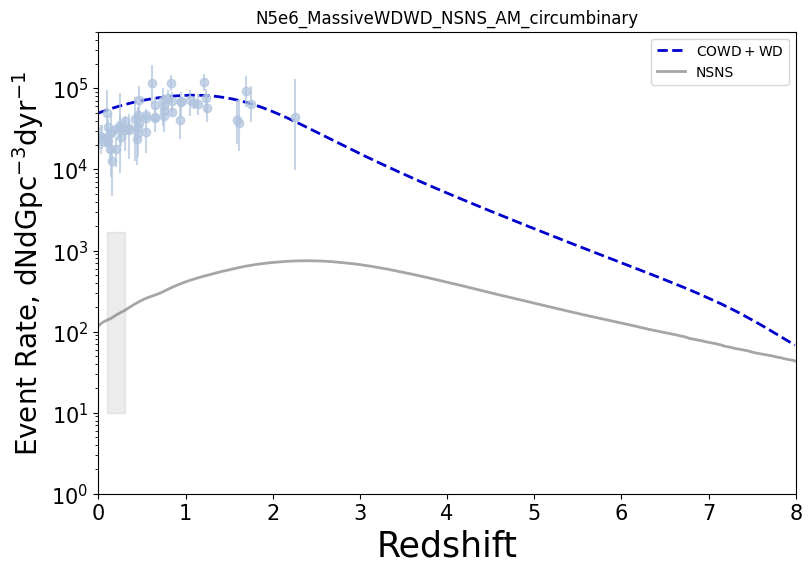

In [3]:
pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
title = 'N5e6_MassiveWDWD_NSNS_AM_circumbinary'
figure_utils.redshift_rates_plotter(pathToH5, title)

For the N5e6 circumbinary the function to plot the redshift vs rates took about 3 minutes

## Metallicity Plot

### 1) Read in the data

In [4]:
# Set the appropriate path to the data file + read in the data

pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
Data  = h5.File(pathToH5, "r")

In [5]:
# we need the metallicities, stellar types, masses, mixture weights, merges hubble time

DCOs = Data['BSE_Double_Compact_Objects']
# gathering the double compact objects that we have computed rates for
DCO_mask = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]

# first we want to investigate how many of each type of DCO there is
stellar_types_1 = DCOs['Stellar_Type(1)'][()][DCO_mask]
stellar_types_2 = DCOs['Stellar_Type(2)'][()][DCO_mask]

# masses
mass1 = DCOs['Mass(1)'][()][DCO_mask]
mass2 = DCOs['Mass(2)'][()][DCO_mask]

# mixture weights
mixture_weights = DCOs['mixture_weight'][()][DCO_mask]

# merges hubble time
merges_compas = DCOs['Merges_Hubble_Time'][()][DCO_mask]

# metallicities
metallicities = DCOs['Metallicity@ZAMS(1)'][()][DCO_mask]

The cell above took about a second to run! I think it just gets longer when we have to read in rates and redshifts

In [6]:
# let's add everything to a dataframe so we can analyze things easier

data = {
  "Stellar_Type(1)": stellar_types_1,
  "Stellar_Type(2)": stellar_types_2,
  "Mass(1)": mass1,
  "Mass(2)": mass2,
  "mixture_weights": mixture_weights,
  "Merges_Hubble_time": merges_compas,
  "Metallicity@ZAMS(1)": metallicities
}

DCOs_masked = pd.DataFrame(data)

### 2) Create the metallicity bins

In [7]:
# let's make evenly spaced metallicity bins in log 
metallicities = np.array(DCOs_masked['Metallicity@ZAMS(1)'])
metallicities_log = np.log10(metallicities)
bins_Z = np.linspace(-4, np.log10(0.03), 20) # making sure we are considereing the bounds of COMPAS

### 3) Counting the systems in each bin

In [8]:
# let's use the "Merges_Hubble_Time" flag to flag when binaries merge and produce graviational waves

merges_comaps_bool = DCOs_masked['Merges_Hubble_time']==1

counts_bins_mergers = pd.cut(np.log10(DCOs_masked['Metallicity@ZAMS(1)'][merges_comaps_bool]), bins=bins_Z).value_counts(sort=False)
counts_bins_mergers

Metallicity@ZAMS(1)
(-4.0, -3.87]       124692
(-3.87, -3.739]     128883
(-3.739, -3.609]    131154
(-3.609, -3.479]    132339
(-3.479, -3.348]    135150
(-3.348, -3.218]    136180
(-3.218, -3.087]    138286
(-3.087, -2.957]    142147
(-2.957, -2.827]    138514
(-2.827, -2.696]    132546
(-2.696, -2.566]    137232
(-2.566, -2.436]    154258
(-2.436, -2.305]    162348
(-2.305, -2.175]    170438
(-2.175, -2.044]    176454
(-2.044, -1.914]    178917
(-1.914, -1.784]    179281
(-1.784, -1.653]    178096
(-1.653, -1.523]    174676
Name: count, dtype: int64

### 4) Computing the star forming mass per binary

In [9]:
# checking the max and min of m1 and m2
list(Data['Run_Details'].keys())
# initial-mass-min, initial-mass-max
print(Data['Run_Details']["initial-mass-min"][0], Data['Run_Details']["initial-mass-max"][0], Data['Run_Details']["minimum-secondary-mass"][0])

print(max(Data['BSE_System_Parameters']['Mass@ZAMS(1)'][()]))
print(min(Data['BSE_System_Parameters']['Mass@ZAMS(1)'][()]))

5.0 150.0 0.1
149.6612197065188
1.0000023635948716


In [10]:
# Defining what constants to use for the star forming mass per binary

m1min = min(Data['BSE_System_Parameters']['Mass@ZAMS(1)'][()])
m1max = max(Data['BSE_System_Parameters']['Mass@ZAMS(1)'][()])
m2min = Data['Run_Details']["minimum-secondary-mass"][0]

# calling the function for star forming mass per binary 
analytical_star_forming_mass_per_binary = utils_from_others.analytical_star_forming_mass_per_binary_using_kroupa_imf(m1min, m1max, m2min)

Integrating from 0.01 to 0.08 for fbin = 1.0 and exponent = -0.3
Integrating from 0.08 to 0.5 for fbin = 1.0 and exponent = -1.3
Integrating from 0.5 to 1 for fbin = 1.0 and exponent = -2.3
Integrating from 1 to 10 for fbin = 1.0 and exponent = -2.3
Integrating from 10 to 200 for fbin = 1.0 and exponent = -2.3


In [11]:
# let's create masks for our systems of intersts so we can plot the metallicity dist for each

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(DCOs_masked)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
COWD_merged = carbon_oxygen_bool*merges_comaps_bool


NSNS_bool = np.logical_and(DCOs_masked["Stellar_Type(1)"]==14, DCOs_masked['Stellar_Type(2)']==14)
NSNS_merged = NSNS_bool*merges_comaps_bool

### 5) Plotting the Metallicity Distirbution

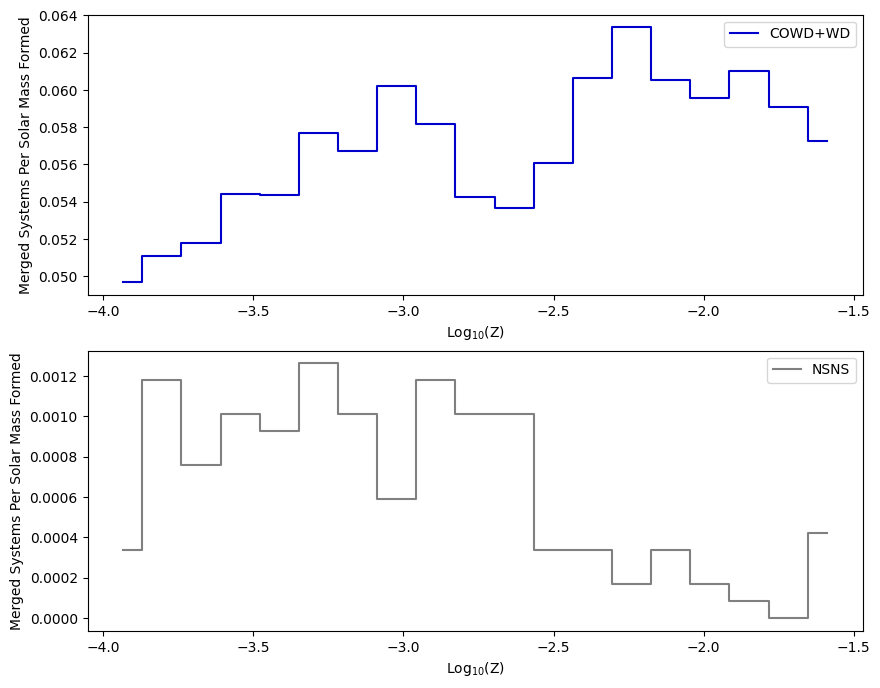

In [16]:
# let's plot our normalized counts vs metallicities!

fig, ax = plt.subplots(2, figsize=(10, 8))

counts_bins_mergers_cowd, bin_edges_mergers_cowd = np.histogram(np.log10(DCOs_masked['Metallicity@ZAMS(1)'][COWD_merged]), weights=DCOs_masked['mixture_weights'][COWD_merged], bins=bins_Z)
# left edges + right edges/2 = center of each bin
center_bins_mergers_cowd = (bin_edges_mergers_cowd[:-1] + bin_edges_mergers_cowd[1:])/2
# we need to consider the bin width so that if we change the normalization constant, the shape stays the same

bin_width_mergers_cowd = np.diff(bin_edges_mergers_cowd)

# we now need to see how we can make the counts we get mroe realistic and rep the universe not just what we simulated
numer_of_binaries_simulated_per_bin = 1e5 #this works because we have systems with metallicites that are uniform in log 
total_SFM_per_bin = analytical_star_forming_mass_per_binary*numer_of_binaries_simulated_per_bin # total SFM that COMPAS simulation represents in each bin - makes hist more realistic 

ax[0].step(center_bins_mergers_cowd, (counts_bins_mergers_cowd/total_SFM_per_bin)/bin_width_mergers_cowd, where='mid', label='COWD+WD', color='mediumblue')


ax[0].set_xlabel(r"$\mathrm{Log_{10}}(\mathrm{Z)}$")
ax[0].set_ylabel(r"Merged Systems Per Solar Mass Formed")
ax[0].legend()




# let's do this again but for NSNS systems

counts_bins_mergers_NSNS, bin_edges_mergers_NSNS = np.histogram(np.log10(DCOs_masked['Metallicity@ZAMS(1)'][NSNS_merged]), weights=DCOs_masked['mixture_weights'][NSNS_merged], bins=bins_Z)
# left edges + right edges/2 = center of each bin
center_bins_mergers_NSNS = (bin_edges_mergers_NSNS[:-1] + bin_edges_mergers_NSNS[1:])/2
# we need to consider the bin width so that if we change the normalization constant, the shape stays the same

bin_width_mergers_NSNS = np.diff(bin_edges_mergers_NSNS)

# we now need to see how we can make the counts we get mroe realistic and rep the universe not just what we simulated
numer_of_binaries_simulated_per_bin = 1e5 #this works because we have systems with metallicites that are uniform in log 
total_SFM_per_bin = analytical_star_forming_mass_per_binary*numer_of_binaries_simulated_per_bin # total SFM that COMPAS simulation represents in each bin - makes hist more realistic 

ax[1].step(center_bins_mergers_NSNS, (counts_bins_mergers_NSNS/total_SFM_per_bin)/bin_width_mergers_NSNS, where='mid', label="NSNS", color='grey')
ax[1].set_xlabel(r"$\mathrm{Log_{10}}(\mathrm{Z)}$")
ax[1].set_ylabel(r"Merged Systems Per Solar Mass Formed")
ax[1].legend()

In [18]:
Data.close()

### 6) Trying out the function

Integrating from 0.01 to 0.08 for fbin = 1.0 and exponent = -0.3
Integrating from 0.08 to 0.5 for fbin = 1.0 and exponent = -1.3
Integrating from 0.5 to 1 for fbin = 1.0 and exponent = -2.3
Integrating from 1 to 10 for fbin = 1.0 and exponent = -2.3
Integrating from 10 to 200 for fbin = 1.0 and exponent = -2.3


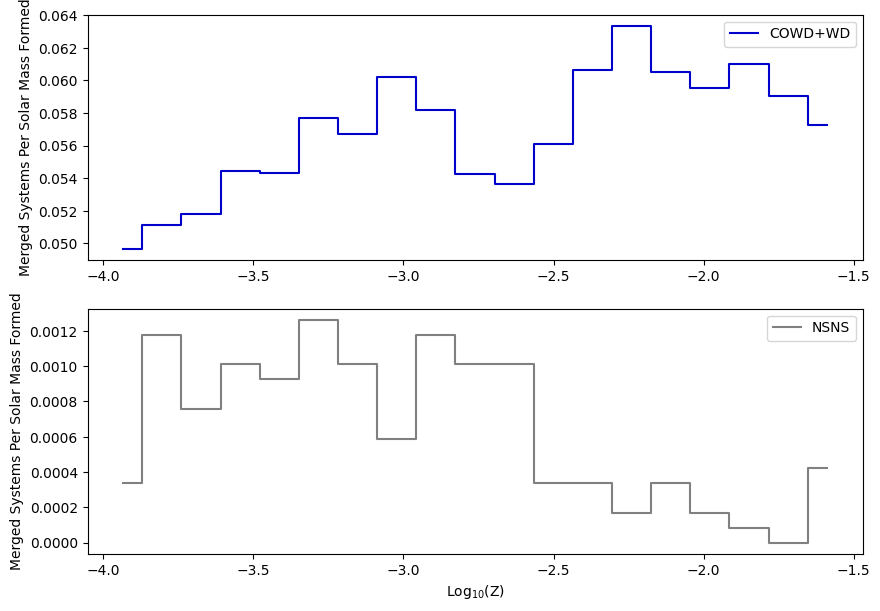

In [2]:
pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
title = 'N5e6_MassiveWDWD_NSNS_AM_circumbinary'
figure_utils.metallicity_plotter(pathToH5, title)

## Time Distribution Plot

### 1) Read in the Data

In [4]:
# Set the appropriate path to the data file + read in the data

pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
Data  = h5.File(pathToH5, "r")

In [5]:
# we want to use information in the double compact object group
DCOs = Data['BSE_Double_Compact_Objects']
# gathering the double compact objects that we have computed rates for
DCO_mask = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]

# first we want to investigate how many of each type of DCO there is
stellar_types_1 = DCOs['Stellar_Type(1)'][()][DCO_mask]
stellar_types_2 = DCOs['Stellar_Type(2)'][()][DCO_mask]


# we need the masses, mixture weight, and rate info
mass1 = DCOs['Mass(1)'][()][DCO_mask]
mass2 = DCOs['Mass(2)'][()][DCO_mask]
mixture_weights = DCOs['mixture_weight'][()][DCO_mask]

# times
lifetimes = DCOs['Time'][()][DCO_mask]
col_times = DCOs['Coalescence_Time'][()][DCO_mask]
delay_times = DCOs['Time'][()][DCO_mask] + DCOs['Coalescence_Time'][()][DCO_mask]


In [6]:
# let's add everything to a dataframe so we can analyze things easier

data = {
  "Stellar_Type(1)": stellar_types_1,
  "Stellar_Type(2)": stellar_types_2,
  "Mass(1)": mass1,
  "Mass(2)": mass2,
  "mixture_weight": mixture_weights,
  "Time": lifetimes,
  "Coalescence_Time": col_times,
  "Delay_Time": delay_times
}

DCOs_masked = pd.DataFrame(data)

### 2) Plot the time distributions

In [7]:
# let's gather our masks for our data so we can plot our systems separately

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(DCOs_masked)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))

NSNS_bool = np.logical_and(DCOs_masked["Stellar_Type(1)"]==14, DCOs_masked['Stellar_Type(2)']==14)


Text(0.5, 1.0, 'NSNS')

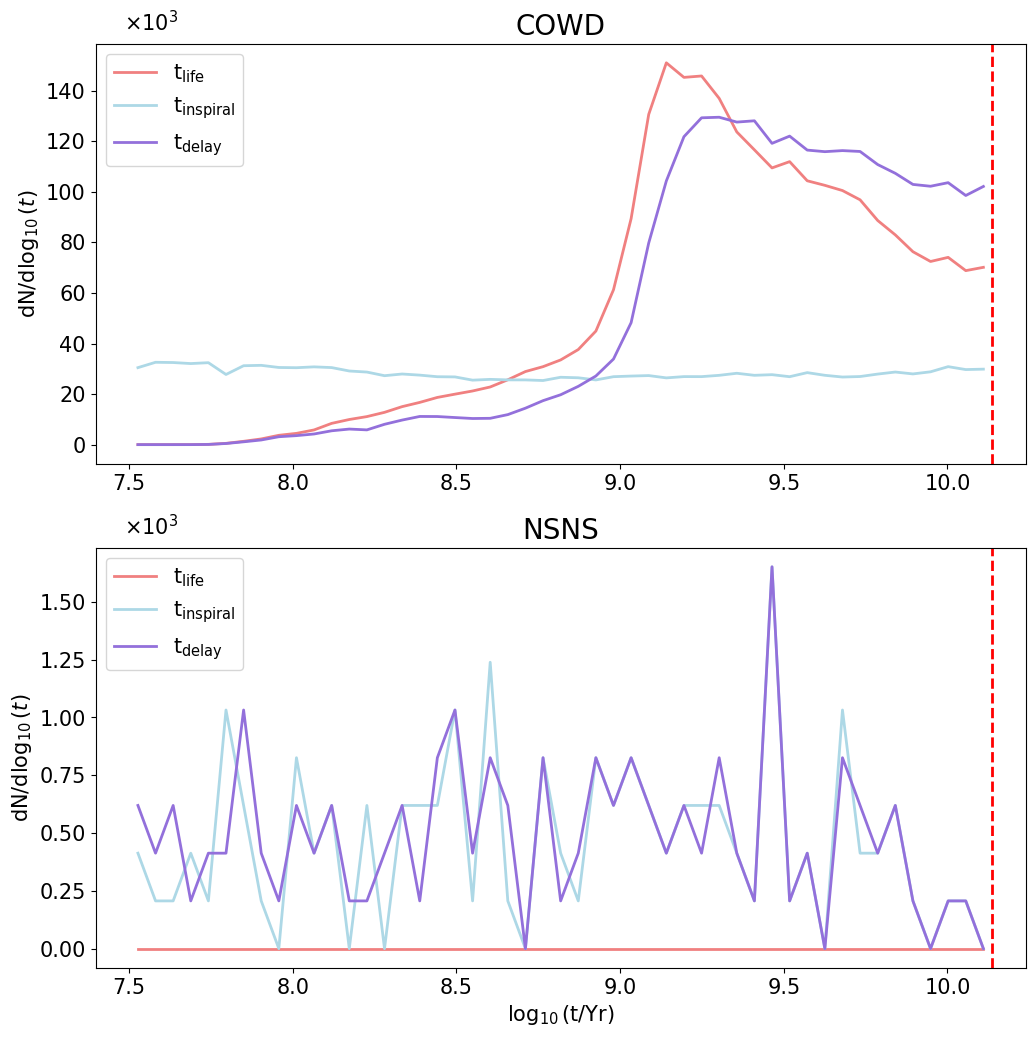

In [17]:
# Let's plot the time distributions!

#Let's first start with the COWD+WD

## hubble time
age_universe = 13.7e9

fig, ax = plt.subplots(2,figsize=(12,12))

## all systems w/ COWD + WD life time
time_life_log_cowd_wd = np.log10((DCOs_masked['Time'][carbon_oxygen_bool]*(1e6)))
hist_cowd_wd_life, bin_edges_cowd_wd_life = np.histogram(time_life_log_cowd_wd, weights=DCOs_masked['mixture_weight'][carbon_oxygen_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_cowd_wd_life = (bin_edges_cowd_wd_life[:-1] + bin_edges_cowd_wd_life[1:])/2
bin_width_cowd_wd_life = np.diff(bin_edges_cowd_wd_life)

ax[0].plot(center_bins_cowd_wd_life,(hist_cowd_wd_life/bin_width_cowd_wd_life)*1e-3,color='lightcoral',lw=2, label=r'$\mathrm{t_{life}}$')

## all systems w/ COWD + WD coalescence time
time_col_log_cowd_wd = np.log10(((DCOs_masked['Coalescence_Time'][carbon_oxygen_bool]*(1e6))))
hist_cowd_wd_col, bin_edges_cowd_wd_col = np.histogram(time_col_log_cowd_wd, weights=DCOs_masked['mixture_weight'][carbon_oxygen_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_cowd_wd_col = (bin_edges_cowd_wd_col[:-1] + bin_edges_cowd_wd_col[1:])/2
bin_width_cowd_wd_col = np.diff(bin_edges_cowd_wd_col)

ax[0].plot(center_bins_cowd_wd_col,(hist_cowd_wd_col/bin_width_cowd_wd_col)*1e-3,color='lightblue',lw=2, label=r'$\mathrm{t_{inspiral}}$')


## all systems w/ COWD + WD delay time
time_delay_log_cowd_wd = np.log10((DCOs_masked['Delay_Time'][carbon_oxygen_bool]*(1e6)))
hist_cowd_wd, bin_edges_cowd_wd = np.histogram(time_delay_log_cowd_wd, weights=DCOs_masked['mixture_weight'][carbon_oxygen_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_cowd_wd = (bin_edges_cowd_wd[:-1] + bin_edges_cowd_wd[1:])/2
bin_width_cowd_wd = np.diff(bin_edges_cowd_wd)

ax[0].plot(center_bins_cowd_wd,(hist_cowd_wd/bin_width_cowd_wd)*1e-3,color='mediumpurple',lw=2, label=r'$\mathrm{t_{delay}}$')




ax[0].text(0.03, 1.03, r'$\times 10^3$', fontsize = 15,  transform = ax[0].transAxes)

# ax[0].set_xlabel(r"$\log_{10}$(t/$\mathrm{Yr}$)",fontsize=15)
# plt.yscale('log')
# plt.xlim(0,15e9)
# plt.ylim(1e-1,1e3)
ax[0].set_ylabel(r"$\mathrm{dN}$/$\mathrm{d}\log_{10}(t$)",fontsize=15) 
ax[0].tick_params(axis='both', which='major', labelsize=15)

ax[0].axvline(np.log10(age_universe), color='r', linestyle='--', linewidth=2)#,label='Hubble Time')
ax[0].legend(fontsize=15)
ax[0].set_title("COWD", fontsize = 20)



# Let's do this again for NSNS systems

## all systems w/ NSNS life time
time_life_log_NSNS = np.log10((DCOs_masked['Time'][NSNS_bool]*(1e6)))
hist_cowd_NSNS_life, bin_edges_cowd_NSNS_life = np.histogram(time_life_log_NSNS, weights=DCOs_masked['mixture_weight'][NSNS_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_cowd_NSNS_life = (bin_edges_cowd_NSNS_life[:-1] + bin_edges_cowd_NSNS_life[1:])/2
bin_width_cowd_NSNS_life = np.diff(bin_edges_cowd_NSNS_life)

ax[1].plot(center_bins_cowd_NSNS_life,(hist_cowd_NSNS_life/bin_width_cowd_NSNS_life)*1e-3,color='lightcoral',lw=2, label=r'$\mathrm{t_{life}}$')

## all systems w/ NSNS coalescence time
time_col_log_NSNS = np.log10(((DCOs_masked['Coalescence_Time'][NSNS_bool]*(1e6))))
hist_cowd_NSNS_col, bin_edges_cowd_NSNS_col = np.histogram(time_col_log_NSNS, weights=DCOs_masked['mixture_weight'][NSNS_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_cowd_NSNS_col = (bin_edges_cowd_NSNS_col[:-1] + bin_edges_cowd_NSNS_col[1:])/2
bin_width_cowd_NSNS_col = np.diff(bin_edges_cowd_NSNS_col)

ax[1].plot(center_bins_cowd_NSNS_col,(hist_cowd_NSNS_col/bin_width_cowd_NSNS_col)*1e-3,color='lightblue',lw=2, label=r'$\mathrm{t_{inspiral}}$')


## all systems w/ NSNS delay time
time_delay_log_NSNS_wd = np.log10((DCOs_masked['Delay_Time'][NSNS_bool]*(1e6)))
hist_NSNS, bin_edges_NSNS = np.histogram(time_delay_log_NSNS_wd, weights=DCOs_masked['mixture_weight'][NSNS_bool],bins=np.linspace(7.5,np.log10(age_universe),50))
center_bins_NSNS = (bin_edges_NSNS[:-1] + bin_edges_NSNS[1:])/2
bin_width_NSNS = np.diff(bin_edges_NSNS)

ax[1].plot(center_bins_NSNS,(hist_NSNS/bin_width_NSNS)*1e-3,color='mediumpurple',lw=2, label=r'$\mathrm{t_{delay}}$')

ax[1].text(0.03, 1.03, r'$\times 10^3$', fontsize = 15,  transform = ax[1].transAxes)

ax[1].set_xlabel(r"$\log_{10}$(t/$\mathrm{Yr}$)",fontsize=15)
# plt.yscale('log')
# plt.xlim(0,15e9)
# plt.ylim(1e-1,1e3)
ax[1].set_ylabel(r"$\mathrm{dN}$/$\mathrm{d}\log_{10}(t$)",fontsize=15) 
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].axvline(np.log10(age_universe), color='r', linestyle='--', linewidth=2)#,label='Hubble Time')
ax[1].legend(fontsize=15)
ax[1].set_title("NSNS", fontsize = 20)

## save figure:
# plt.savefig("./figures/delaytime_distributions_COWD.png",bbox_inches='tight',pad_inches=0.1)

In [25]:
Data.close()

### 3) Let's try out the function

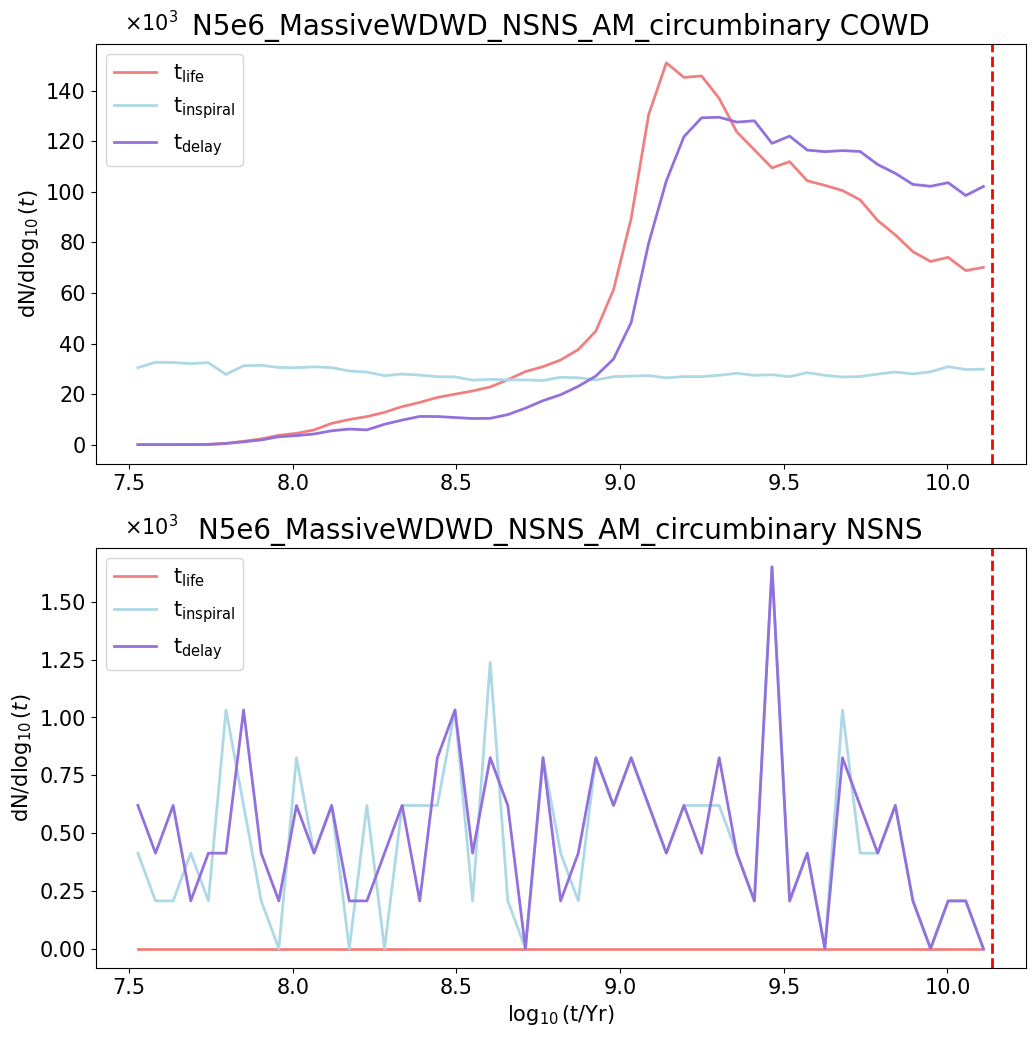

In [3]:
pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
title = 'N5e6_MassiveWDWD_NSNS_AM_circumbinary'
figure_utils.time_dist_plotter(pathToH5, title)